Домашнее задание:

1) Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох, можно изменять число слоев)

2) Проведите анализ - что приводит к ухудшнию точности неронной сети? что приводит к увеличению ее точности?

In [ ]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронной сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [ ]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов

def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j + 1
    return arr

# вычисление функции сигмоида
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# вычисление производной функции сигмоида
def sigmoid_deriv(x):
  # return sigmoid(x) * (1 - sigmoid(x))
  return (x) * (1 - (x))

# нормализация массива 
def normalize(X, axis = -1, order = 2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


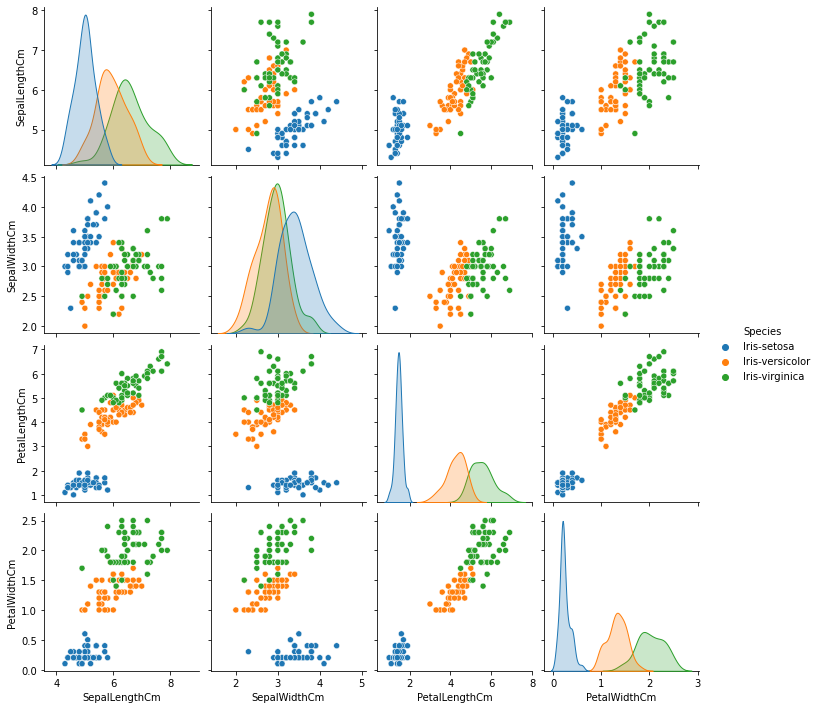

In [ ]:
### Шаг 2. Подготовка тренировочных данных
# получение данных из csv файла. укажите здесь путь к файлу Iris.csv

iris_data = pd.read_csv("Iris.csv")
print(iris_data.head()) # раскомментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # раскомментируйте, чтобы позырить

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace = True)

# формирование входных данных
columns = ['SepalLengthCm', 'PetalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns = columns)
# x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных (результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns = columns)
# y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)


Для того, чтобы проводить эксперименты я создал класс IrisNeuralNetwork. При его инициализации задаются гиперпараметры, которые являются характеристиками сети.

У него есть метод fit. Который получает на вход данные для обучения.
И есть 3 метода

get_errors - выдает список ошибок на каждом шаге обучения

get_accuracy - выдает список аккуратности на каждом шаге обучения

get_predict - выдает полученное в процессе обучения значение для последнего слоя.



In [ ]:
class IrisNeuralNetwork:

    neurons_layers_composition= [] # Список количества нейроно в слоях. Количество элементов в списке - количество слоев.
    weights = [] # список списков начальных весов. Для каждого слоя.
    learning_rate = 0.05 # скорость обучения
    number_of_epochs = 10000 # Количество эпох (циклов обучения)

    def __init__(self, neurons_layers_composition=None, learning_rate=0.05, number_of_epochs=10000, weights=[]):
        
        self.X_train = X_train    
        self.X_test = X_test    
        self.y_train =  y_train   
        self.y_test = y_test    
        self.learning_rate = learning_rate    
        self.number_of_epochs = number_of_epochs

        self.errors = None
        self.errors = []
        self.accuracy = None
        self.accuracy = []
        self.predict = None
        self.predict = []

        if neurons_layers_composition is None:
            self.neurons_layers_composition = np.array([4, 1, 3]) # По-умолчанию будет создана сеть с 3-мя слоями. Входной, выходной и промежуточный с одним нейроном
        else:
            default_list = []
            for el in neurons_layers_composition:
                default_list.append(el)
            self.neurons_layers_composition = np.array(default_list)

        if weights is None:
            np.random.seed(None)
            w0 = 2*np.random.random((4, 1)) - 1
            w1 = 2*np.random.random((1, 3)) - 1
            self.weights = [w0, w1] # Веса для сети по-умолчанию
        else:
            default_list = []
            for el in weights:
                default_list.append(el)
            self.weights = default_list

    def fit(self, X_train, X_test, y_train, y_test):

        for i in range(self.number_of_epochs):

            layer = X_train
            layers = [layer]
            # прямое распространение (feet forward)
            for lay_i in range(len(self.neurons_layers_composition)-1):
                layer = sigmoid(np.dot(np.array(layers[lay_i]), self.weights[lay_i]))
                layers.append(layer)

            # обратное распространение (back propagation) с использованием градиентного спуска
            # Первый подшаг необходимо сделать отдельно, т.к. в нем расчет ошибки отталкивается от y_train
            # Дальнейшее обратное распространение основано на умножении уже имеющихся данных на коеэффициенты
            lay_i = len(self.neurons_layers_composition)-1
            layer_error = y_train - layers[lay_i]
            layer_delta = layer_error * sigmoid_deriv(layers[lay_i])

            # метрика модели, фиксация ошибки
            error = np.mean(np.abs(layer_error))
            self.errors.append(error)
            self.accuracy.append((1 - error) * 100)
            self.predict = layers[lay_i]

            # рассчитаем ошибку для следующего шага со старым весом
            # т.к. этот вес будет изменен уже на текущем шаге
            layer_error = layer_delta.dot(self.weights[lay_i-1].T)
            # коррекция
            self.weights[lay_i-1] += layers[lay_i-1].T.dot(layer_delta) * self.learning_rate

            for lay_i in range(len(self.neurons_layers_composition)-2, 0, -1):
                layer_delta = layer_error * sigmoid_deriv(layers[lay_i])

                # рассчитаем ошибку для следующего шага со старым (пока это возможно) весом
                layer_error = layer_delta.dot(self.weights[lay_i-1].T)

                # коррекция весов
                self.weights[lay_i-1] += layers[lay_i-1].T.dot(layer_delta) * self.learning_rate

    def get_errors(self):
        return self.errors

    def get_accuracy(self):
        return self.accuracy

    def get_predict(self):
        return self.predict


In [ ]:
def generate_wights(nlc=None):
    if nlc is None:
        nlc = np.array([4, 1, 3]) # По-умолчанию будет создана сеть с 3-мя слоями. Входной, выходной и промежуточный с одним нейроном

    result = None
    result = []
    np.random.seed(100)
    for i in range(len(nlc)-1):
        w = 2*np.random.random((nlc[i], nlc[i+1])) - 1  # для входного слоя - 4 входа, 3 - выхода
        result.append(w)
    
    # print(result)
    # print(np.array(result, dtype=object))

    # return(np.array(result, dtype=object))
    return result


Для начала поиздевамся над сетью с одинм нейроном в единственном неслужебном слое

Ошибки в сети [4 1 3] при количестве эпох = 1: [0.47612320244015316]
Ошибки в сети [4 1 3] при количестве эпох = 4: [0.47612320244015316, 0.4731136957692532, 0.4701887244468804, 0.46736244852516573]
Ошибки в сети [4 1 3] при количестве эпох = 7: [0.47612320244015316, 0.4731136957692532, 0.4701887244468804, 0.46736244852516573, 0.46465458231983614, 0.4620862521845483, 0.459676643596212]
Ошибки в сети [4 1 3] при количестве эпох = 10: [0.47612320244015316, 0.4731136957692532, 0.4701887244468804, 0.46736244852516573, 0.46465458231983614, 0.4620862521845483, 0.459676643596212, 0.45744064567220544, 0.45538757096079585, 0.453520858041815]
Ошибки в сети [4 1 3] при количестве эпох = 13: [0.47612320244015316, 0.4731136957692532, 0.4701887244468804, 0.46736244852516573, 0.46465458231983614, 0.4620862521845483, 0.459676643596212, 0.45744064567220544, 0.45538757096079585, 0.453520858041815, 0.4518385303461027, 0.45033412640626824, 0.44899783270977517]
Ошибки в сети [4 1 3] при количестве эпох = 1

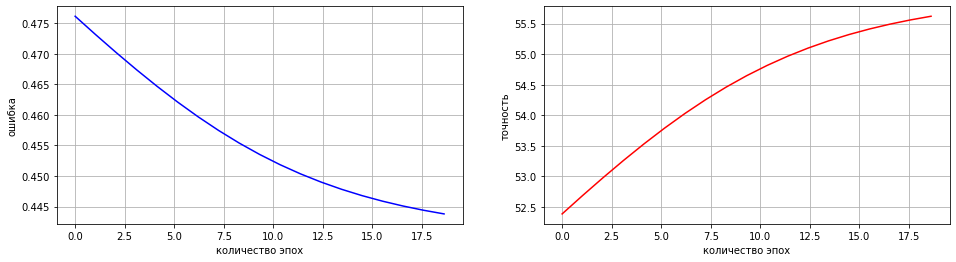

In [ ]:
learning_rate = 0.05
max_noe_count = 30

nlc = np.array([4, 1, 3])
np.random.seed(100)

for number_of_epochs in range(1, 20, 3):
    wm = generate_wights(nlc) # решил генерировать каждый раз новый массив (но с одинаковыми закрепленными системными параметрами) 
                              # поскольку внутри array хранятся ссылки на массивы. И в результате написать код корректного 
                              # копирования будет такой же по затратам времени и ресурсв, как и новая генерация.

    IrisNN = None    
    IrisNN = IrisNeuralNetwork(neurons_layers_composition=nlc, learning_rate=learning_rate, number_of_epochs=number_of_epochs, weights=wm)
    IrisNN.fit(X_train, X_test, y_train, y_test)
    errors = IrisNN.get_errors()
    print(f'Ошибки в сети {nlc} при количестве эпох = {number_of_epochs}: {errors}')

accuracy = IrisNN.get_accuracy()

X = np.linspace(0, max_noe_count, max_noe_count)
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('ошибка')
plt.plot(X[0:len(errors)], errors,'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('точность')
plt.plot(X[0:len(accuracy)], accuracy,'-r')

plt.show()


Очевидно, что ошибка уменьшается. И значит точность сети будет только увеличиваться. Пусть теперь будет 10 000 эпох.

<Figure size 1152x288 with 0 Axes>

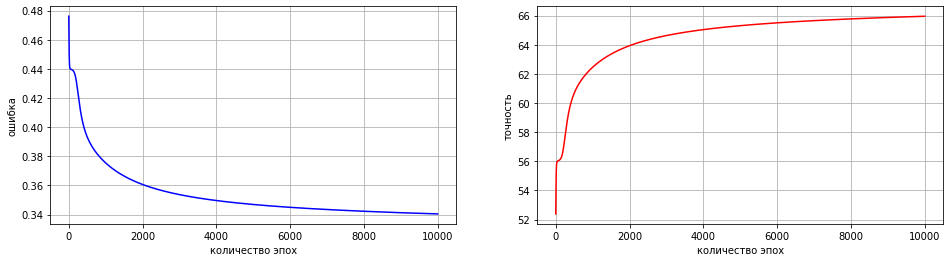

In [ ]:
learning_rate = 0.05
max_noe_count = 10000

nlc = np.array([4, 1, 3])
np.random.seed(100)
wm = generate_wights(nlc) 
number_of_epochs = max_noe_count # создал эту ненужную строку, чтобы не вносить корректировки в дальнейший код и не запутаться

IrisNN = None    
IrisNN = IrisNeuralNetwork(neurons_layers_composition=nlc, learning_rate=learning_rate, number_of_epochs=number_of_epochs, weights=wm)
IrisNN.fit(X_train, X_test, y_train, y_test)
errors = IrisNN.get_errors()
accuracy = IrisNN.get_accuracy()

X = np.linspace(0, max_noe_count, max_noe_count)

plt.figure(figsize=(16, 4))
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('ошибка')
plt.plot(X[0:len(errors)], errors,'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('точность')
plt.plot(X[0:len(accuracy)], accuracy,'-r')

plt.show()

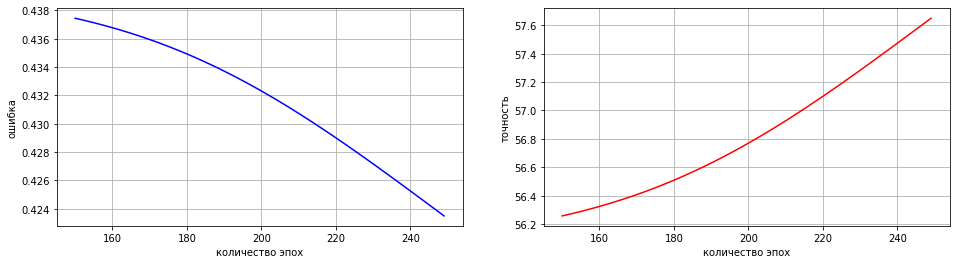

In [ ]:
X = np.linspace(0, max_noe_count, max_noe_count)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('ошибка')
plt.plot(X[150:250], errors[150:250],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('точность')
plt.plot(X[150:250], accuracy[150:250],'-r')

plt.show()

Ух-ты, даже качественный "скачек" (точнее падение ошибки) в районе 200 эпох.

Но точность на одном слое с одним нейроном выше 66% не растет.

Стоит попробовать увеличить число нейронов

[1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]


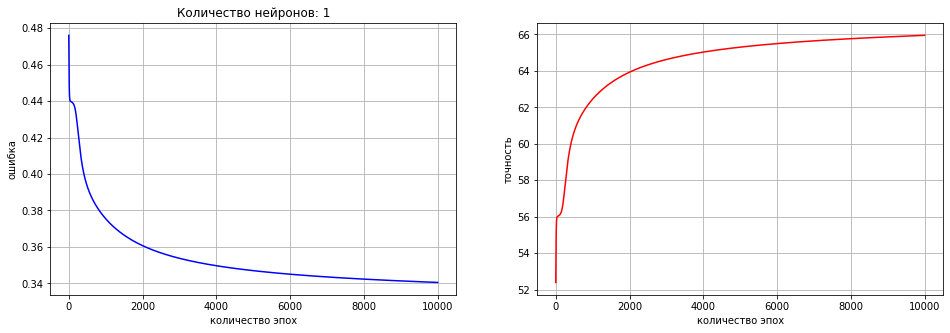

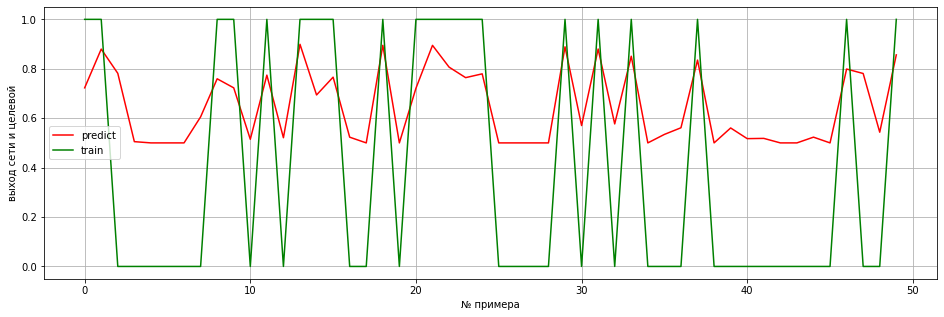

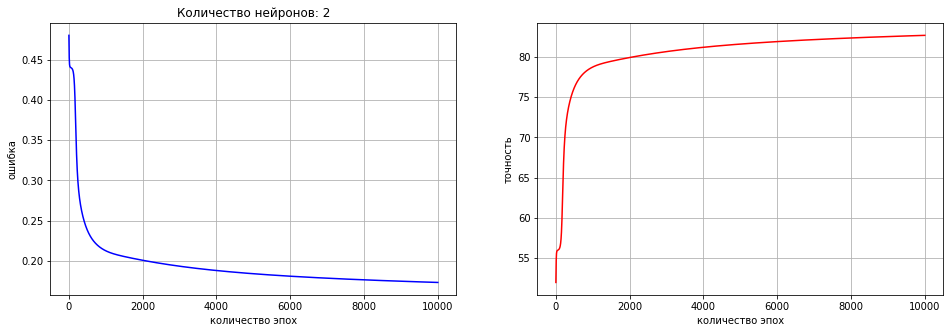

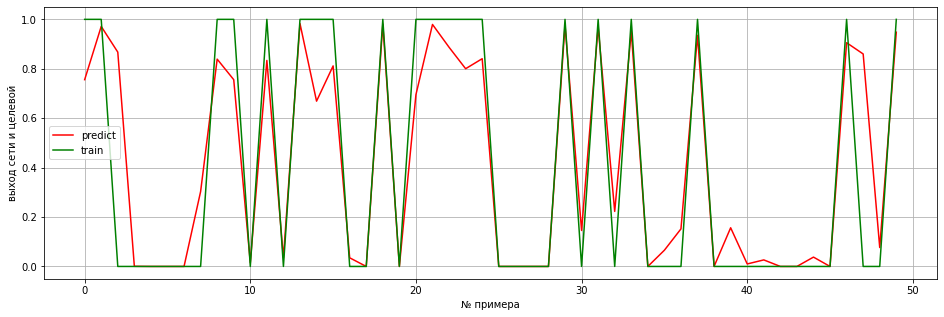

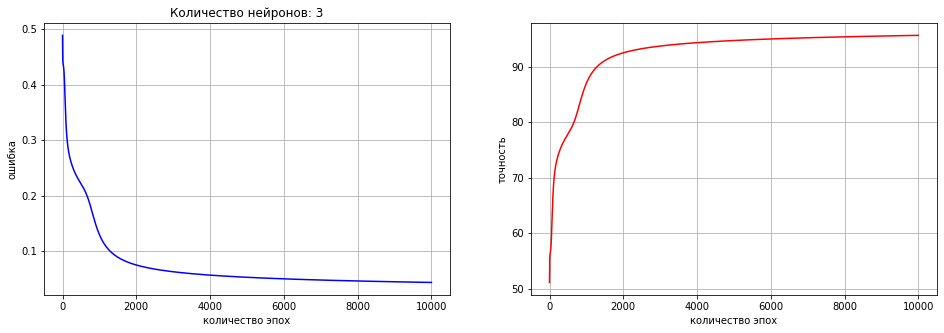

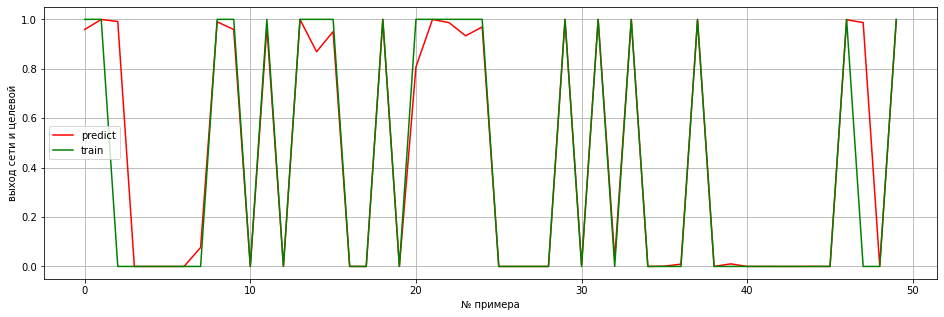

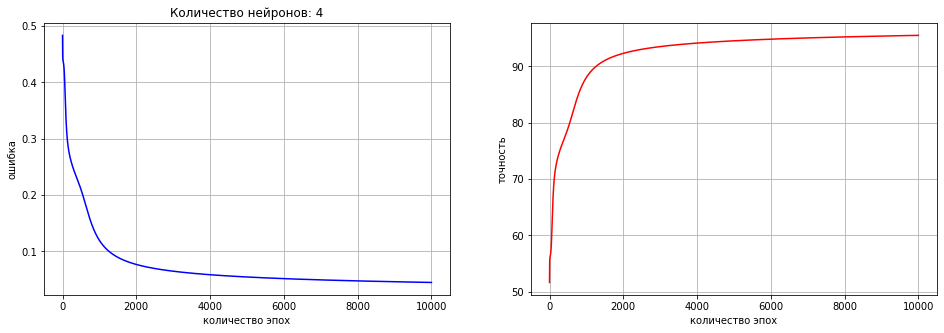

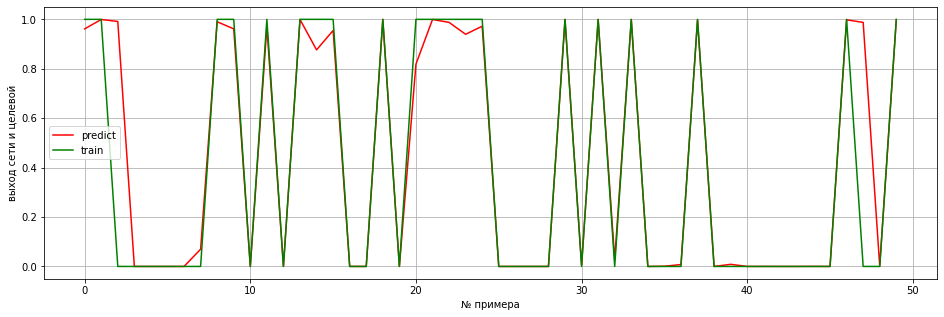

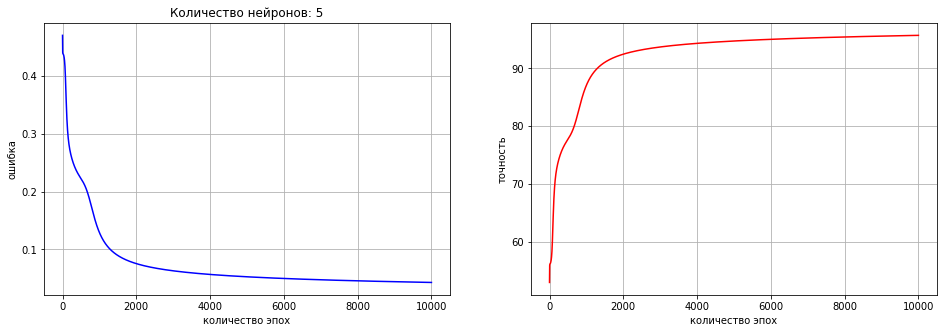

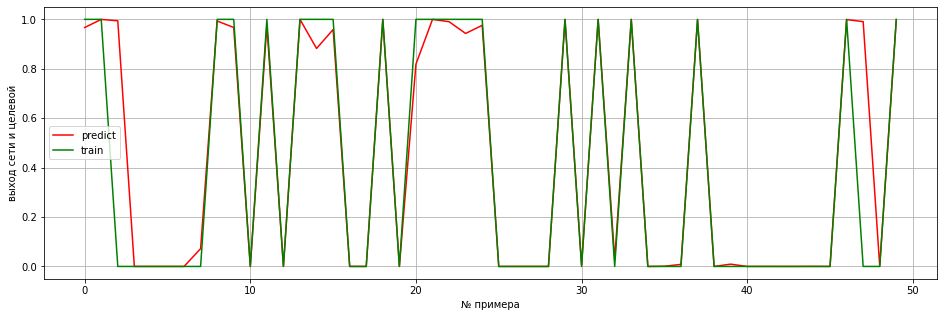

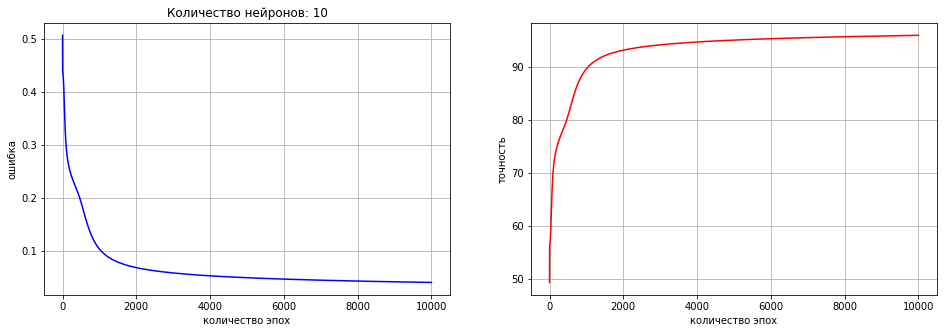

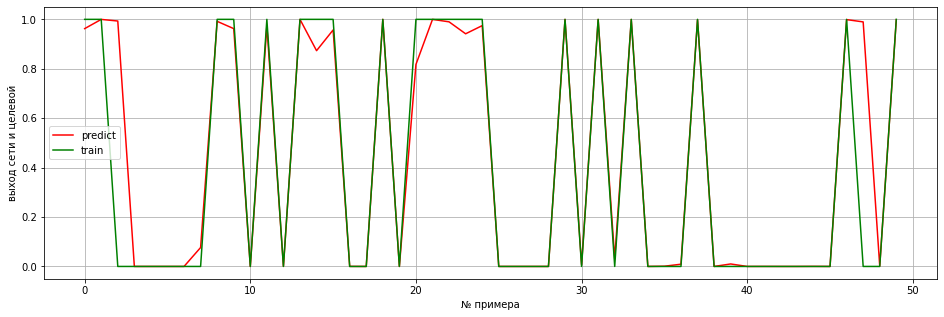

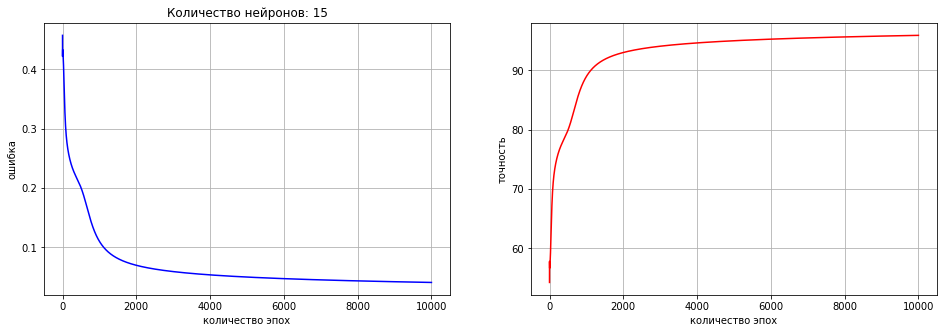

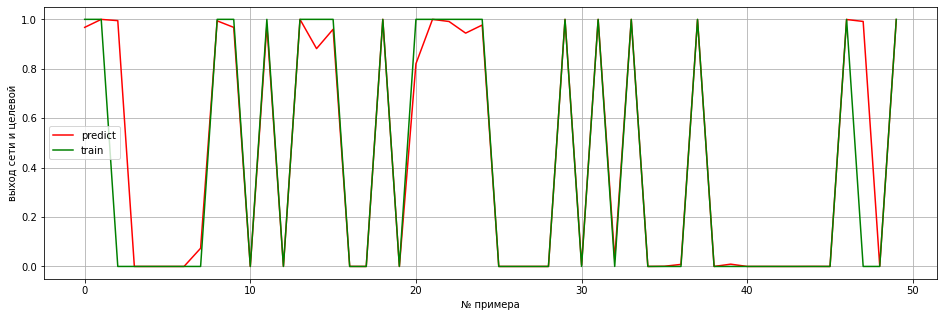

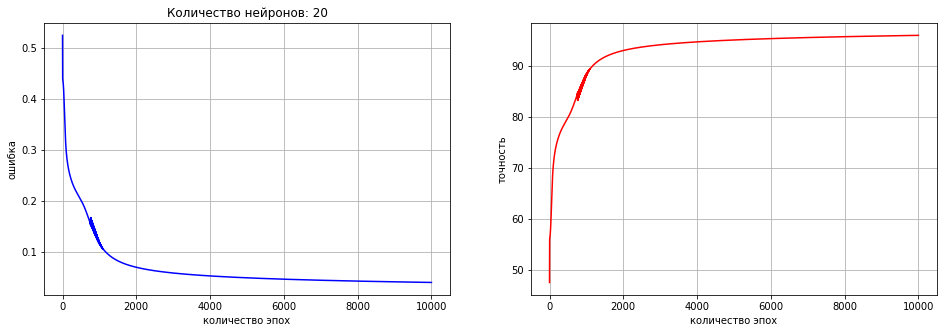

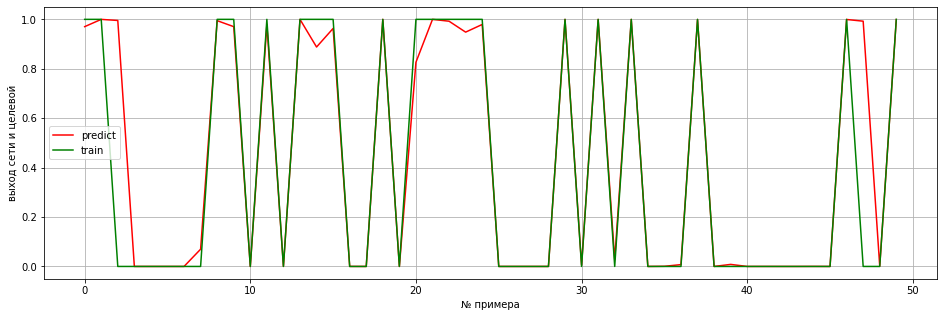

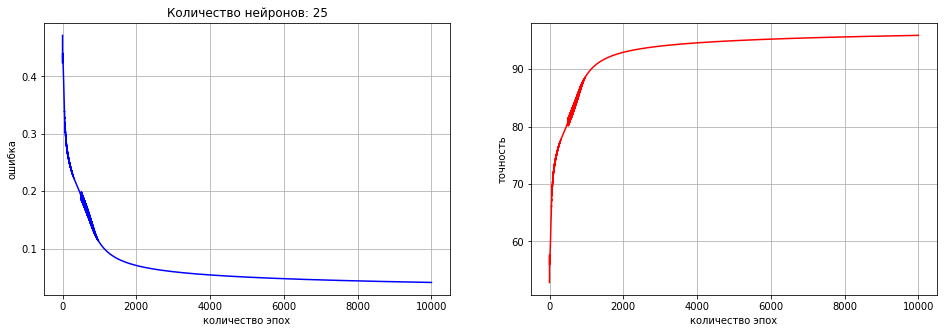

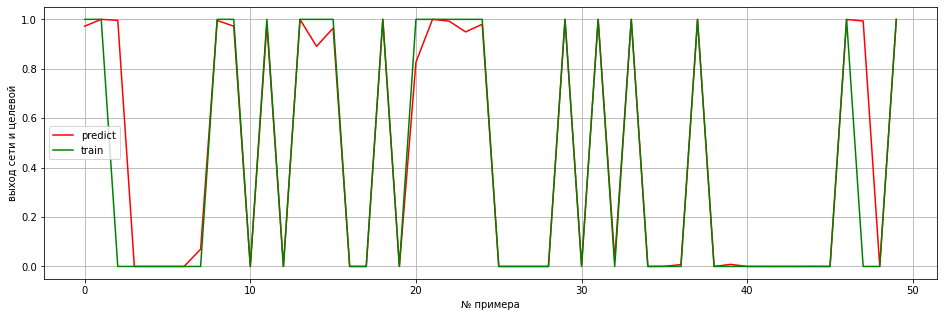

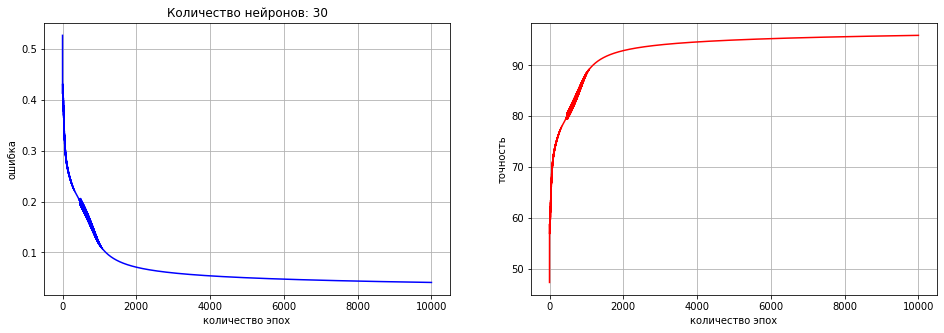

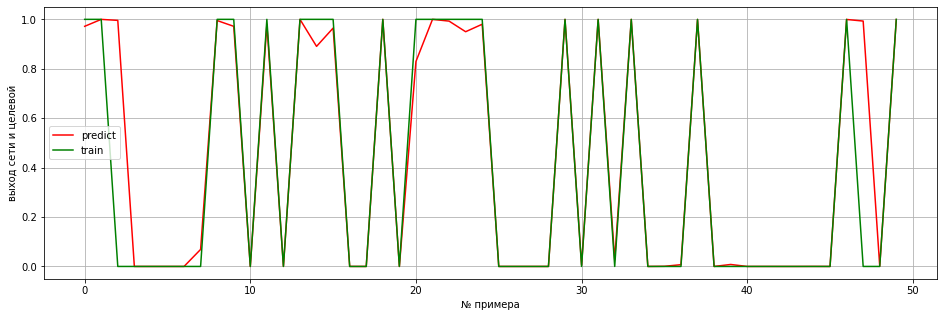

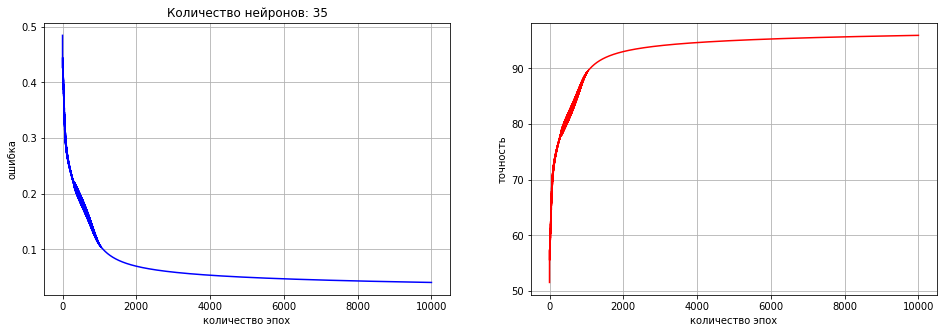

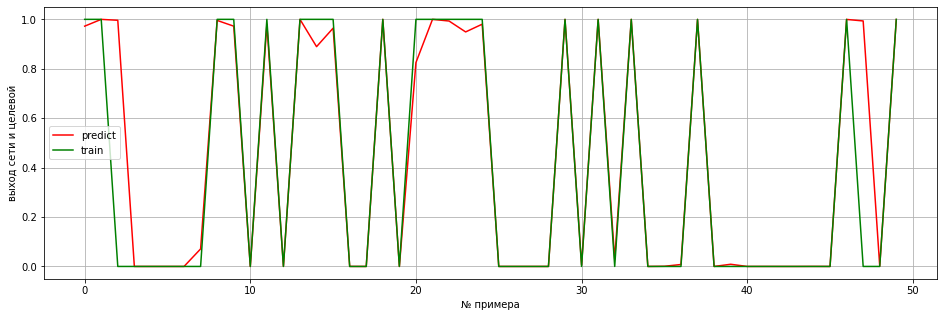

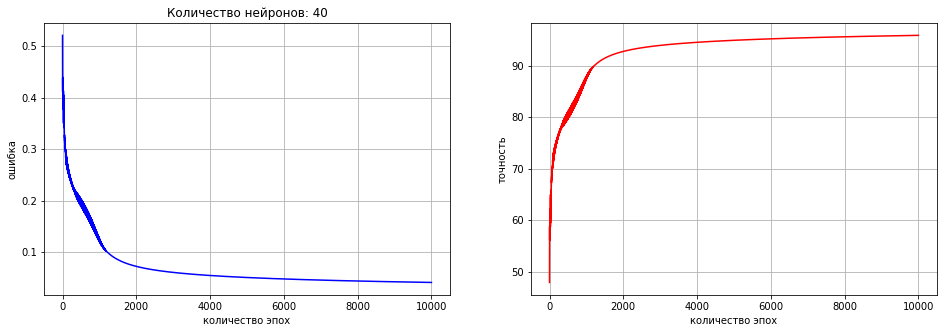

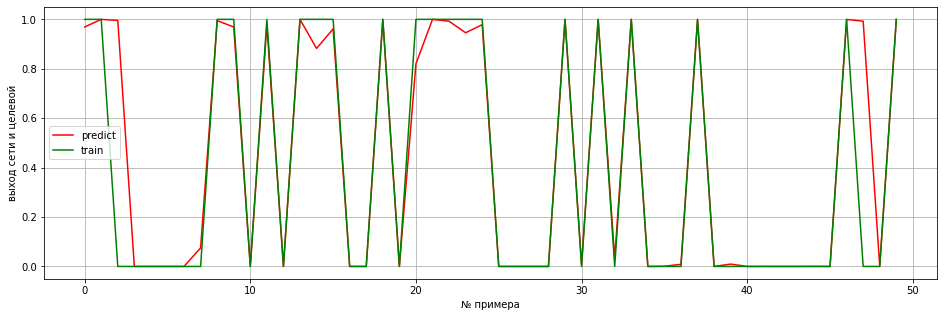

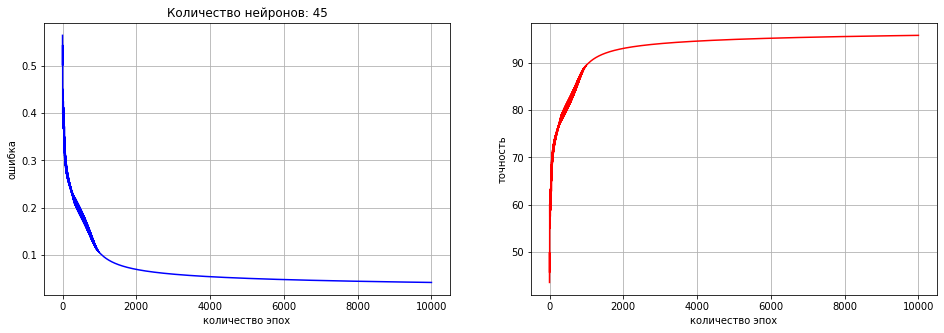

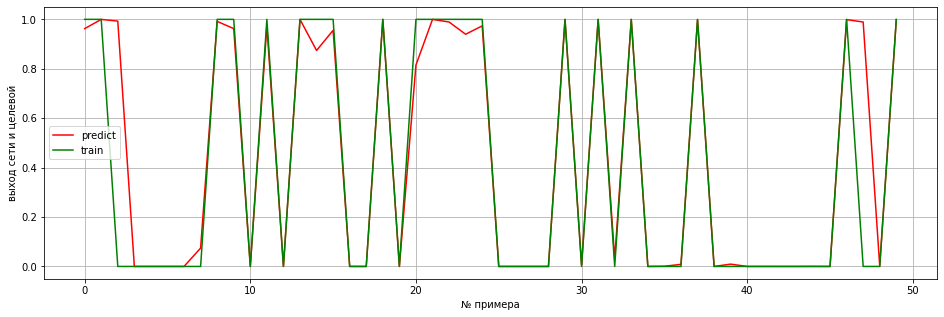

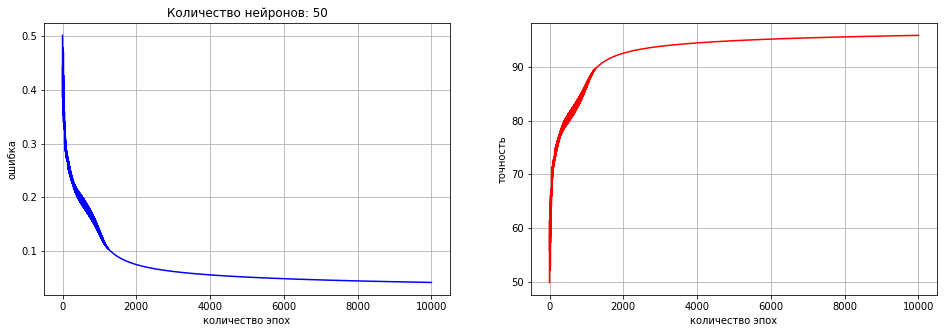

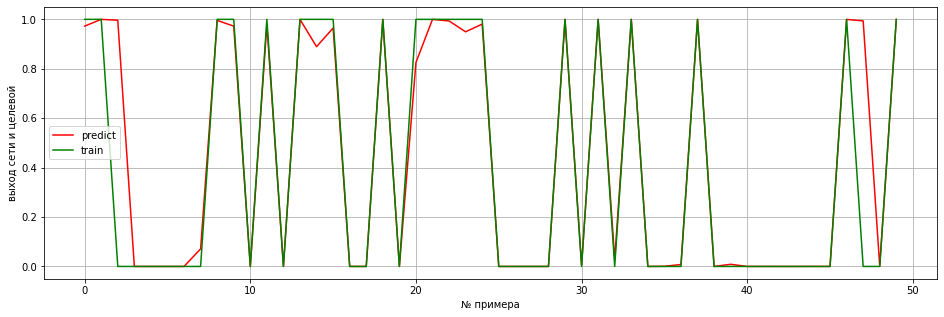

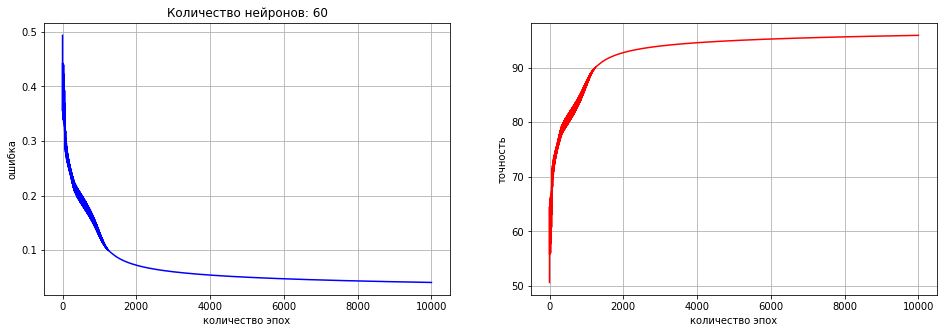

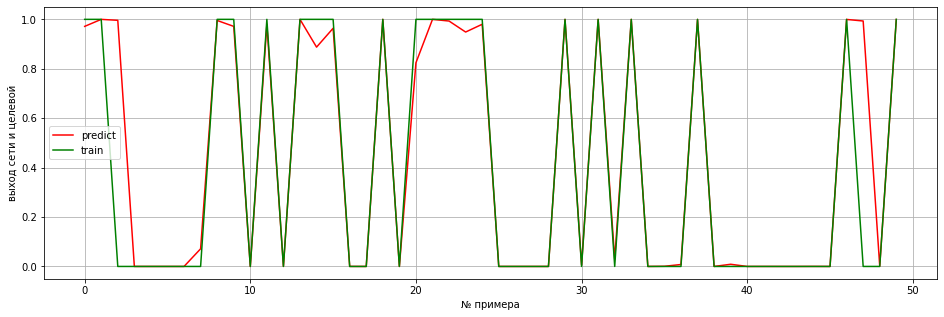

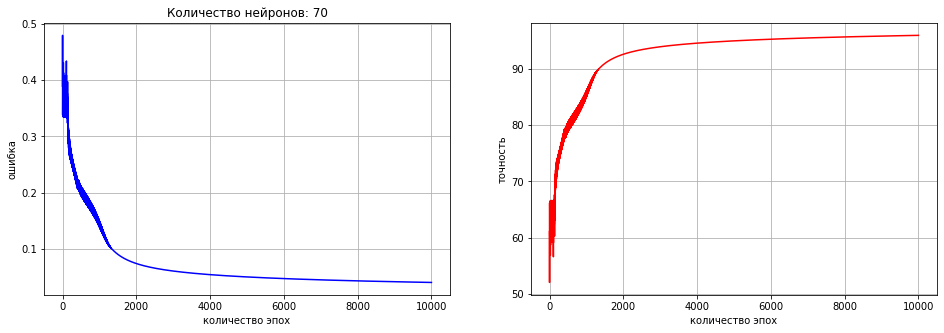

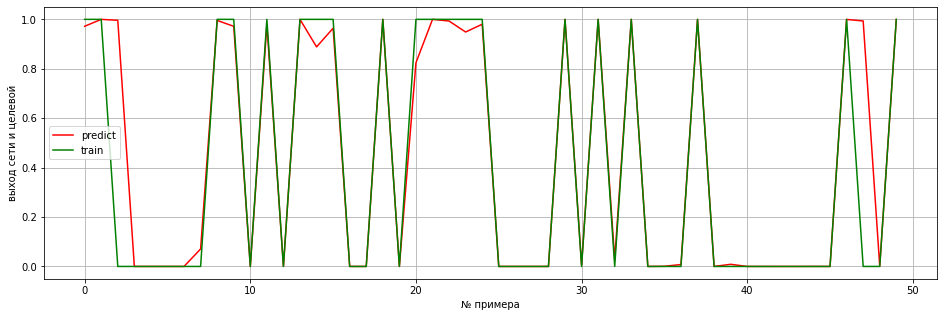

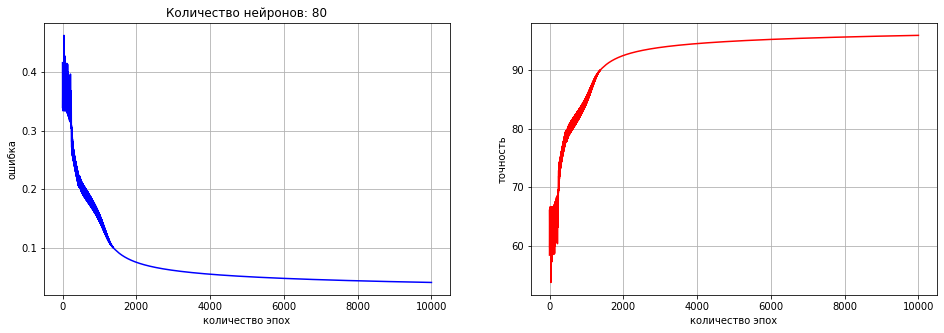

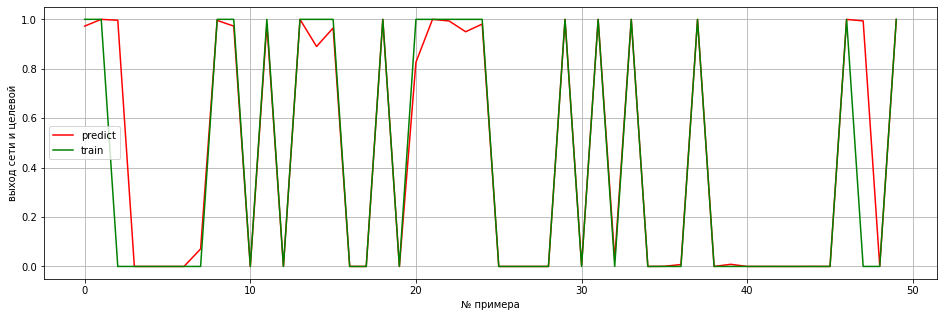

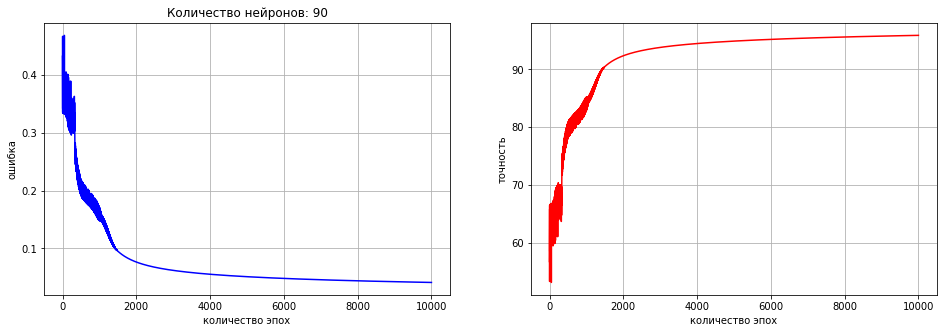

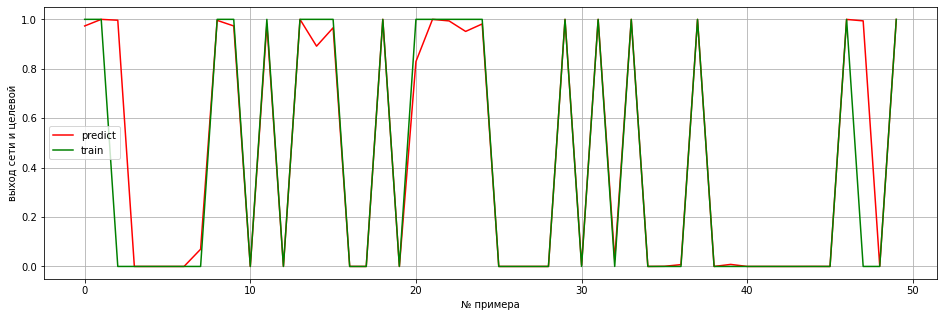

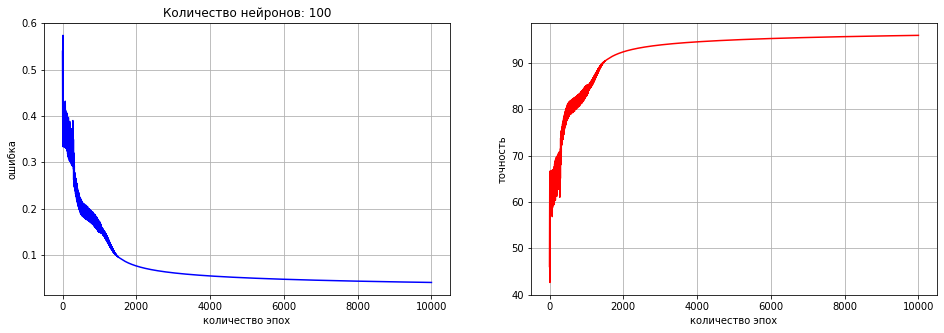

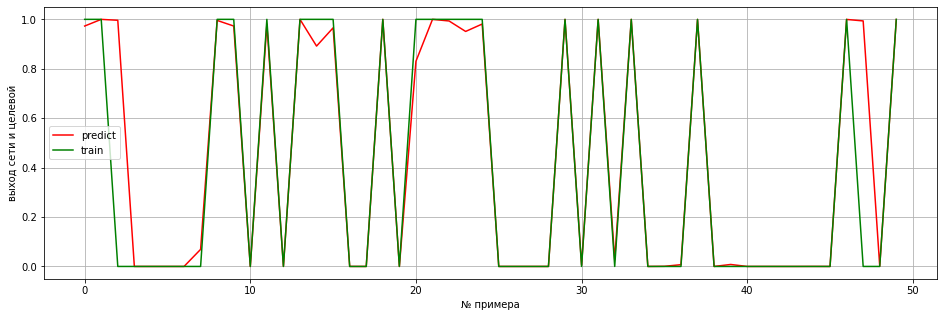

In [ ]:
learning_rate = 0.05
number_of_epochs = 10000
X = np.linspace(0, number_of_epochs, number_of_epochs)
N = 50 # Вспомогательный параметр для сравнения результатов

nlc = np.array([4, 1, 3])
np.random.seed(100)

experiments = list(range(1, 6, 1))
experiments += list(range(10, 51, 5))
experiments += list(range(60, 101, 10))

print(experiments)

for number_of_neurons in experiments:
    nlc = None
    nlc = np.array([4, number_of_neurons, 3])
    np.random.seed(100)
    wm = generate_wights(nlc) # решил генерировать каждый раз новый массив (но с одинаковыми закрепленными системными параметрами) 
                              # поскольку внутри array хранятся ссылки на массивы. И в результате написать код корректного 
                              # копирования будет такой же по затратам времени и ресурсв, как и новая генерация.

    IrisNN = None    
    IrisNN = IrisNeuralNetwork(neurons_layers_composition=nlc, learning_rate=learning_rate, number_of_epochs=number_of_epochs, weights=wm)
    IrisNN.fit(X_train, X_test, y_train, y_test)
    errors = IrisNN.get_errors()
    accuracy = IrisNN.get_accuracy()
    predict = IrisNN.get_predict()

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Количество нейронов: {number_of_neurons}')
    plt.grid('On')
    plt.xlabel('количество эпох')
    plt.ylabel('ошибка')
    plt.plot(X[0:len(errors)], errors,'-b')

    plt.subplot(1, 2, 2)
    plt.grid('On')
    plt.xlabel('количество эпох')
    plt.ylabel('точность')
    plt.plot(X[0:len(accuracy)], accuracy,'-r')

    plt.figure(figsize=(16, 5))
    plt.plot(predict[:N, 1], 'r', label = 'predict')
    plt.plot(y_train[:N, 1], 'g', label = 'train')
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
print(f'Финальная ошибка: {errors[9999]}')
print(f'Финальная точность: {accuracy[9999]}')

Финальная ошибка: 0.040644706654544296
Финальная точность: 95.93552933454556


К своей максимальной точности 95.93 сеть добирается уже при трех нейронах. Что кажется нормальным, т.к. выходов тоже 3. И 2 нейрона явно не справляются с "угадыванием" правильного выхода.

Но наблюдается странное поведение сети на первых 2000 эпох. Которое, тем не менее выравнивается при дальнейшем обучении. Есть предположение, что большое число нейронов мешают работе градиентного спуска. Т.е. требуется большее число эпох, чтобы добиться от всех нейронов слаженной работы. Пока их всех уговоришь .... Хорошо, что ими првавит математика, а не демократия. Но в итоге, это удается.

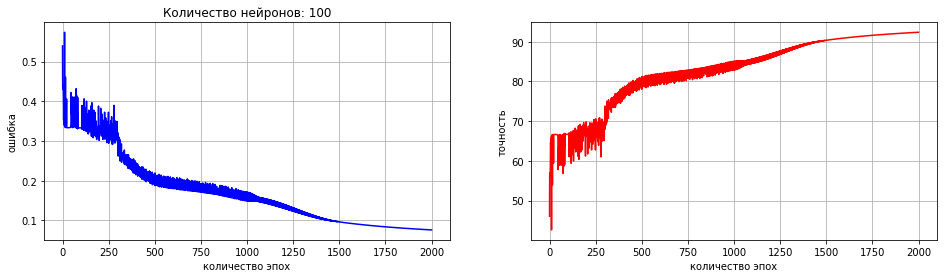

In [ ]:
plt.figure(figsize=(16, 4))
    
plt.subplot(1, 2, 1)
plt.title(f'Количество нейронов: {number_of_neurons}')
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('ошибка')
plt.plot(X[0:2000], errors[0:2000],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('точность')
plt.plot(X[0:2000], accuracy[0:2000],'-r')

plt.show()

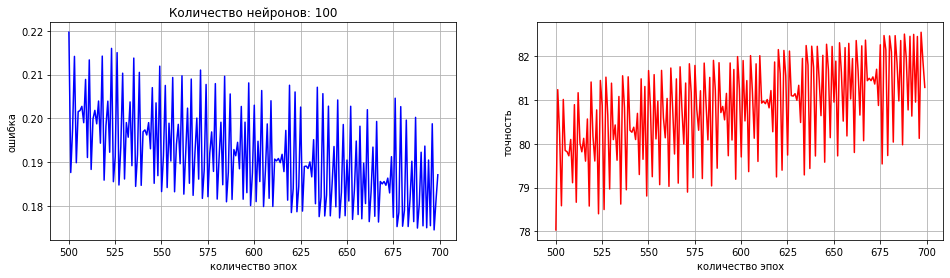

In [ ]:
plt.figure(figsize=(16, 4))
    
plt.subplot(1, 2, 1)
plt.title(f'Количество нейронов: {number_of_neurons}')
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('ошибка')
plt.plot(X[500:700], errors[500:700],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('точность')
plt.plot(X[500:700], accuracy[500:700],'-r')

plt.show()

И на последок, попробуем увеличивать число слоев. По 3 нейрона в каждом.

[4 3 3]
Финальная ошибка: 0.04338731815295604. Финальная аккуратность: 95.6612681847044


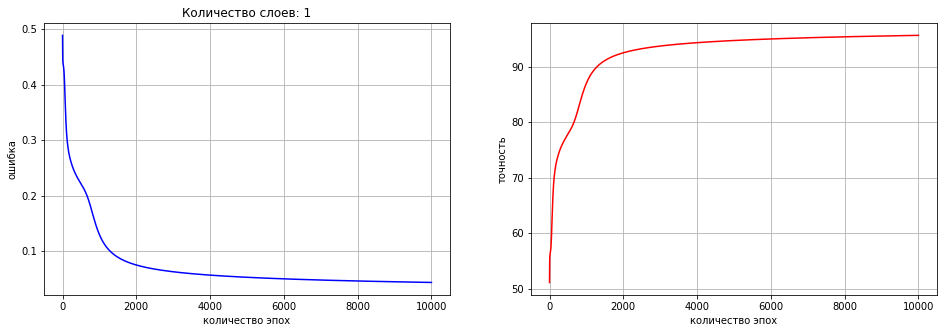

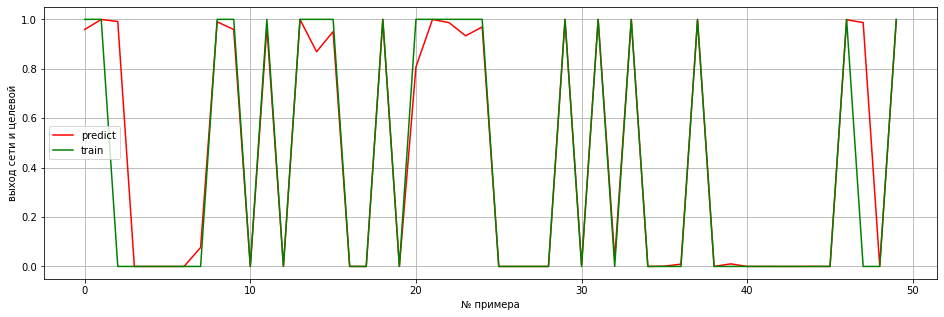

[4 3 3 3]
Финальная ошибка: 0.04332754743811799. Финальная аккуратность: 95.66724525618821


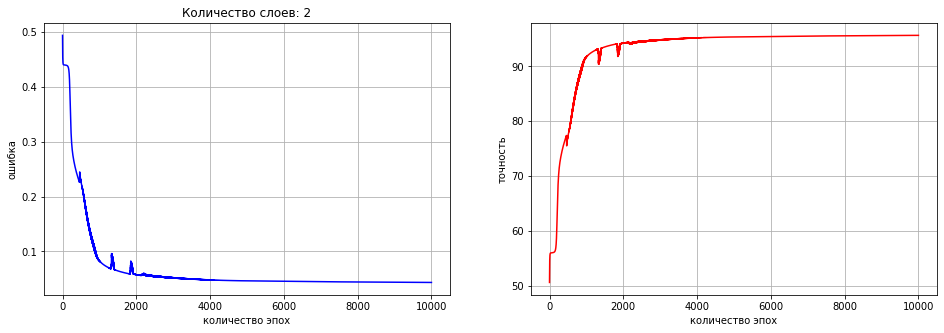

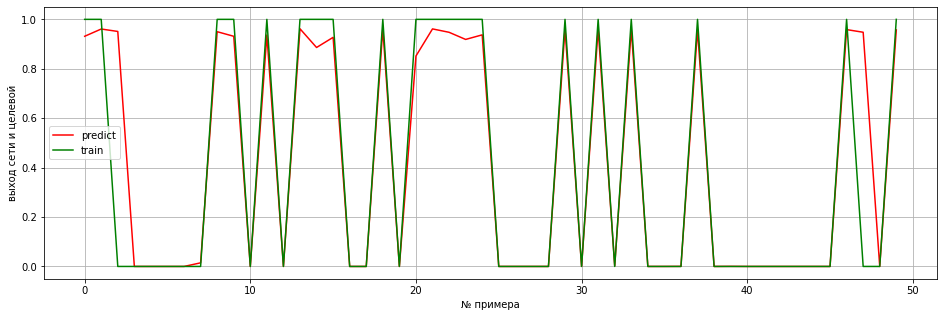

[4 3 3 3 3]
Финальная ошибка: 0.04647960927006256. Финальная аккуратность: 95.35203907299375


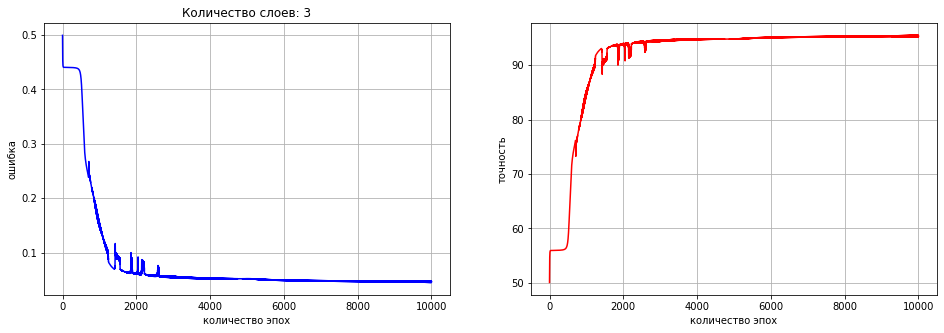

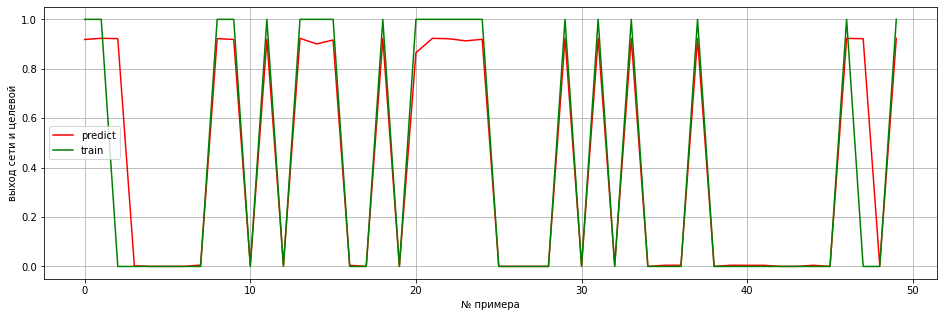

[4 3 3 3 3 3]
Финальная ошибка: 0.045411524738935324. Финальная аккуратность: 95.45884752610647


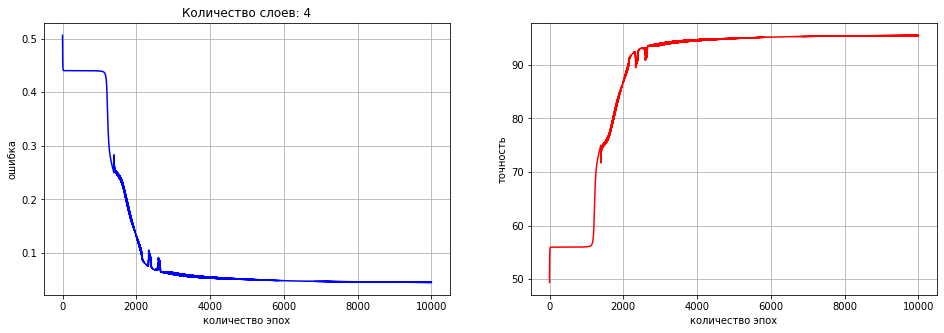

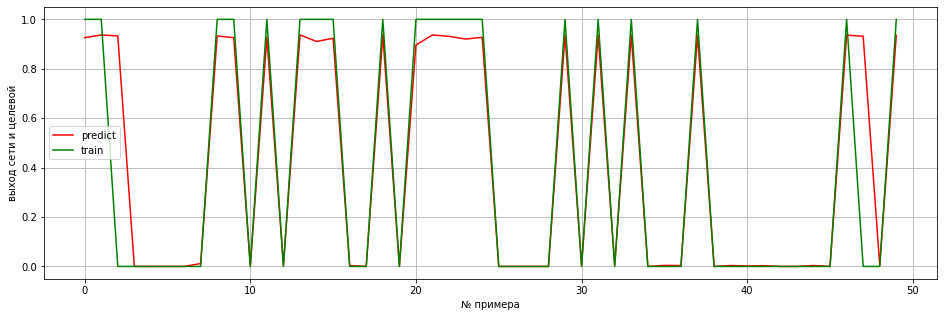

[4 3 3 3 3 3 3]
Финальная ошибка: 0.04927110565736776. Финальная аккуратность: 95.07288943426322


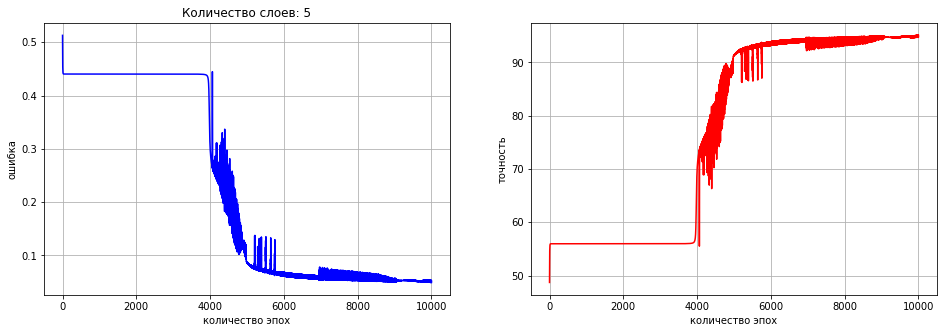

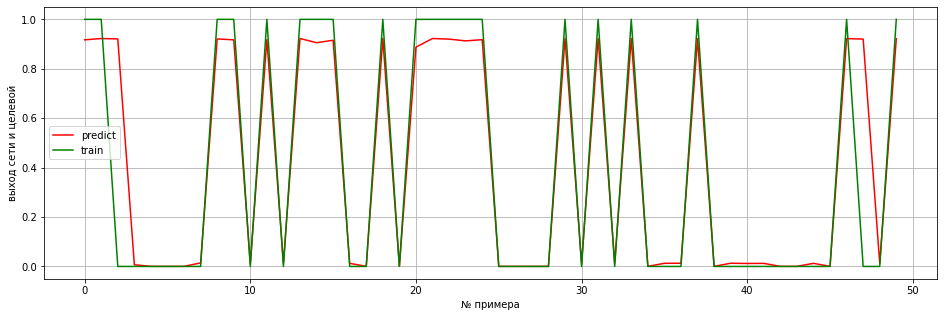

[4 3 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.44040000012074265. Финальная аккуратность: 55.959999987925734


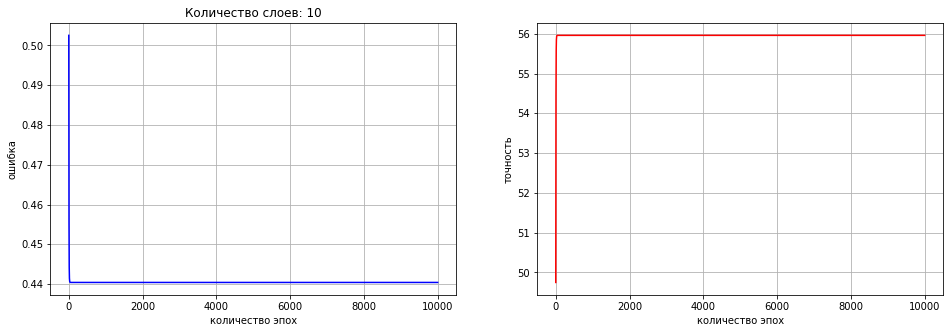

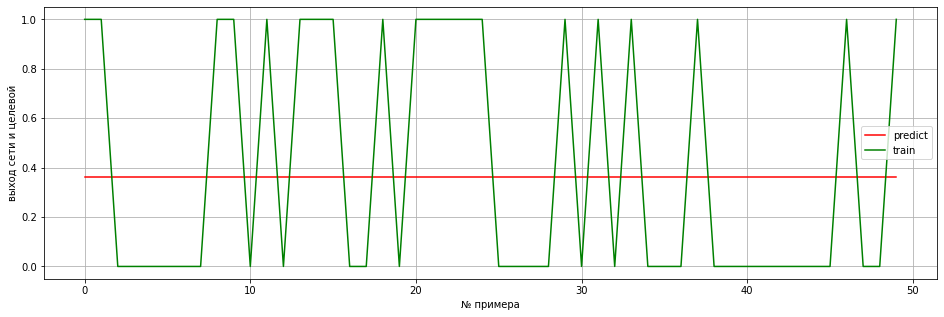

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.4403999999999677. Финальная аккуратность: 55.96000000000323


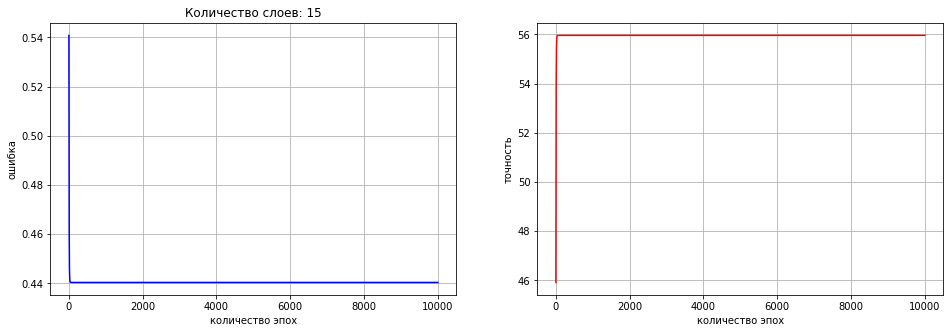

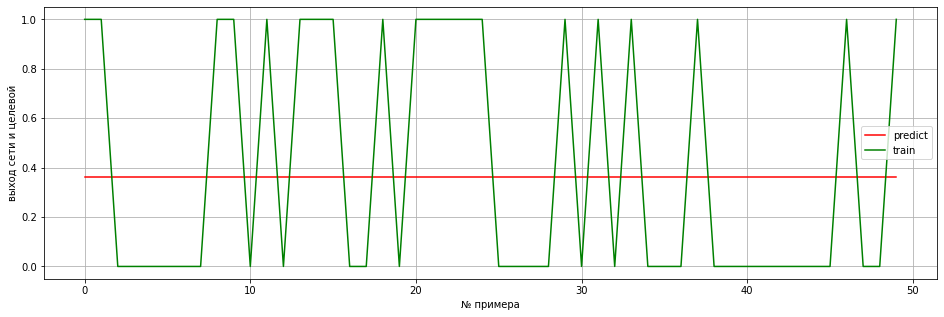

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.4404. Финальная аккуратность: 55.96


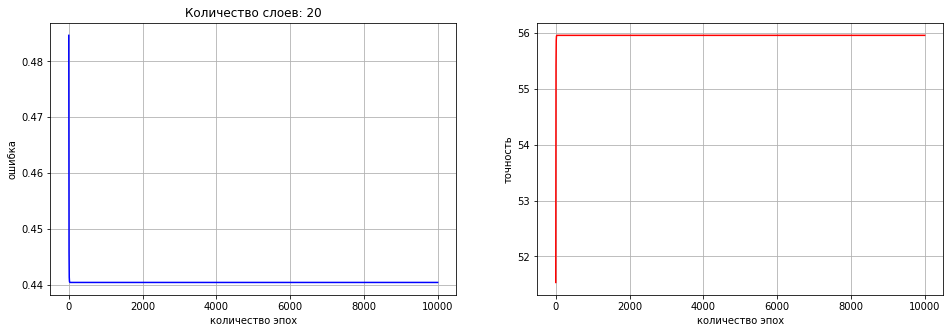

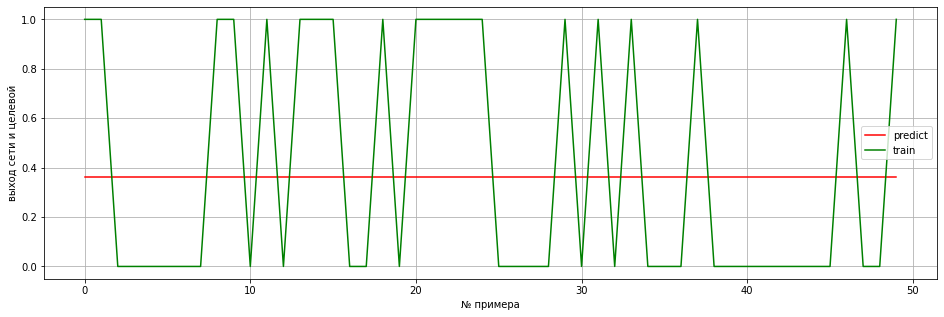

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.4404. Финальная аккуратность: 55.96


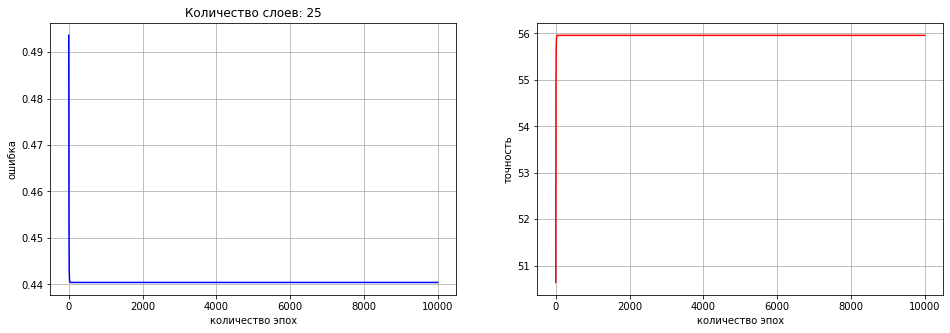

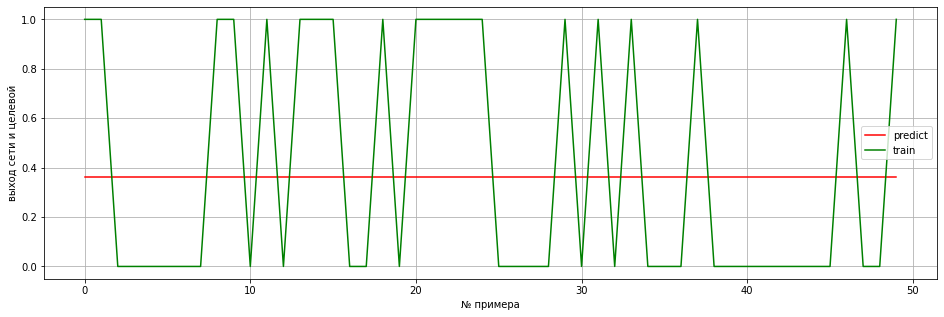

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.4404. Финальная аккуратность: 55.96


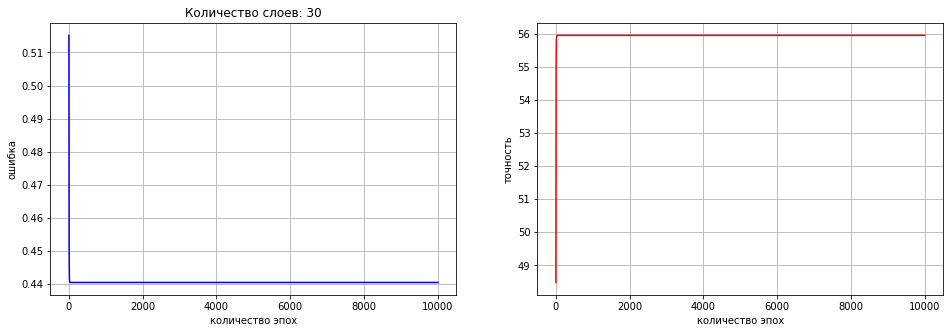

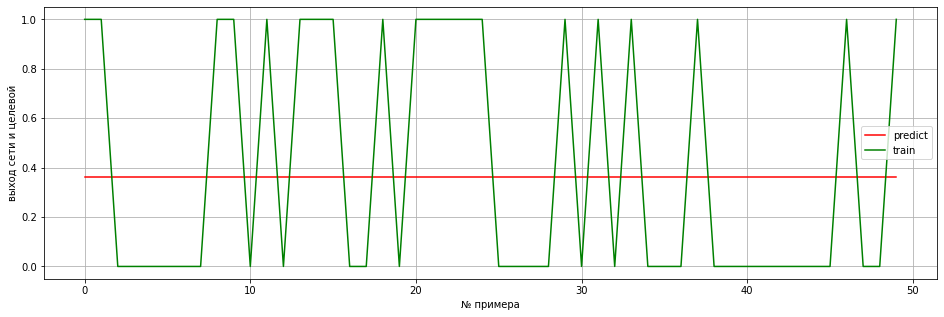

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.4404. Финальная аккуратность: 55.96


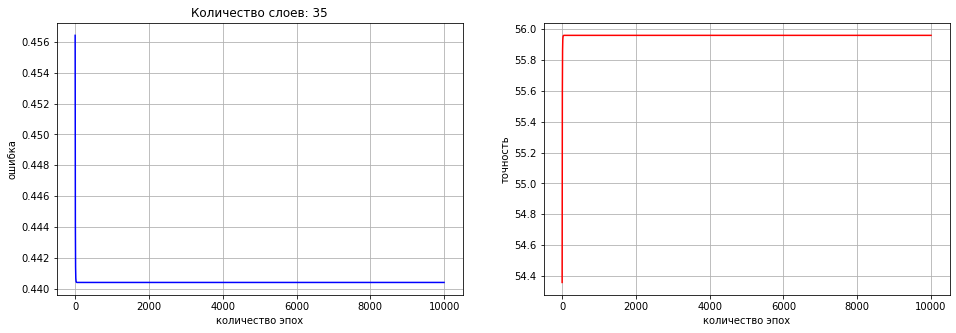

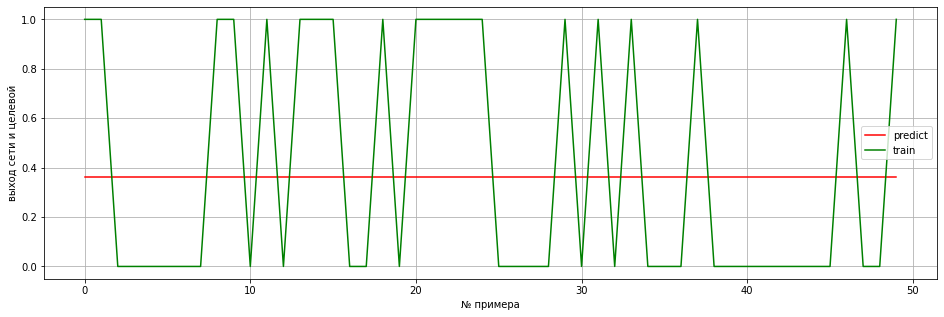

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3]
Финальная ошибка: 0.4404. Финальная аккуратность: 55.96


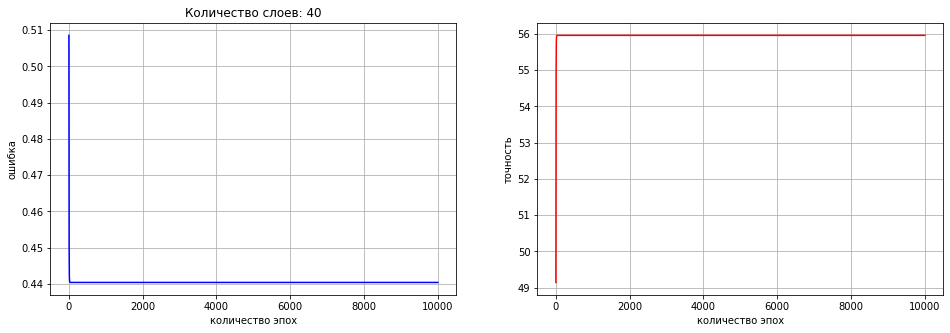

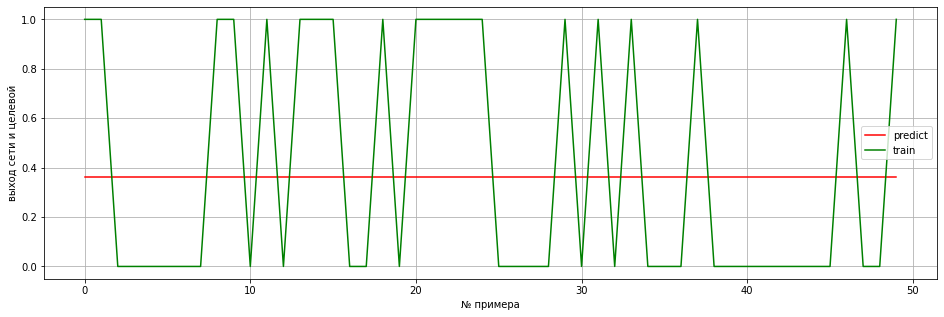

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.4404. Финальная аккуратность: 55.96


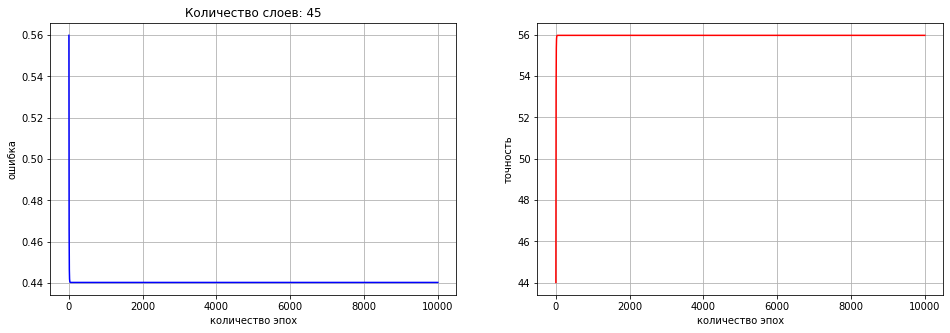

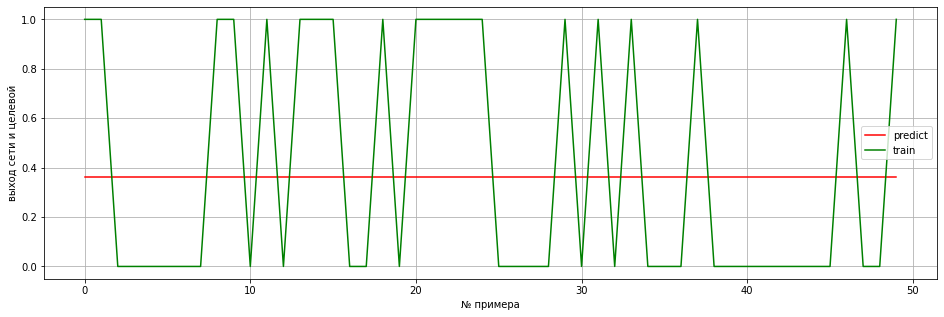

[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Финальная ошибка: 0.4404. Финальная аккуратность: 55.96


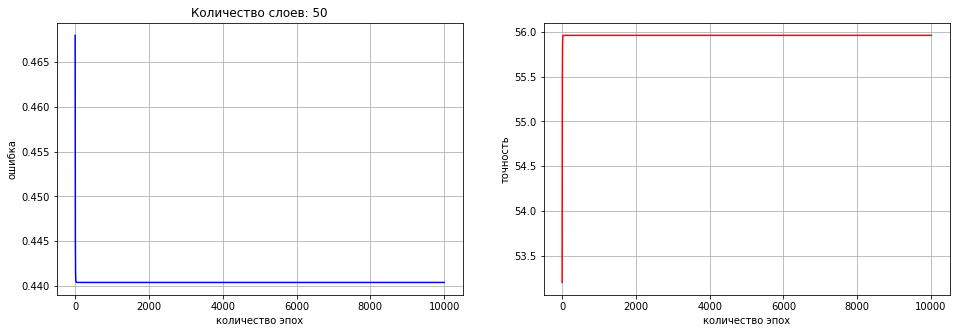

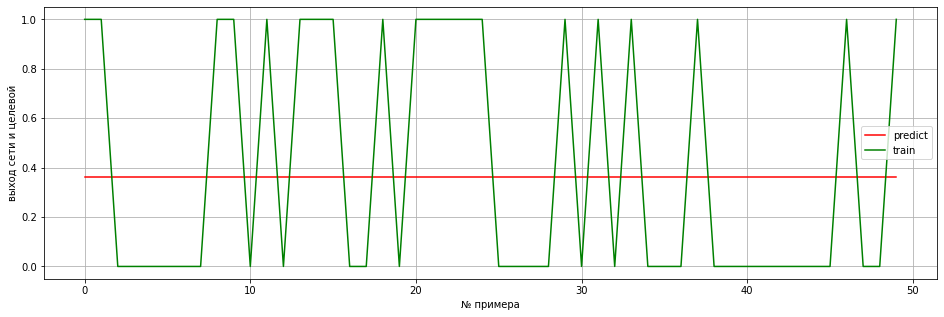

In [ ]:
learning_rate = 0.05
number_of_epochs = 10000
number_of_neurons = 3

X = np.linspace(0, number_of_epochs, number_of_epochs)
N = 50 # Вспомогательный параметр для сравнения результатов

nlc = np.array([4, 1, 3])
np.random.seed(100)

experiments = list(range(1, 6, 1))
experiments += list(range(10, 51, 5))
# experiments += list(range(60, 101, 10))

for number_of_layers in experiments:
    pred_nlc = [4]
    for i in range(number_of_layers):
        pred_nlc += [3]
    pred_nlc += [3]
    
    nlc = None
    nlc = np.array(pred_nlc)
    print(nlc)
    np.random.seed(100)
    wm = generate_wights(nlc) # решил генерировать каждый раз новый массив (но с одинаковыми закрепленными системными параметрами) 
                              # поскольку внутри array хранятся ссылки на массивы. И в результате написать код корректного 
                              # копирования будет такой же по затратам времени и ресурсв, как и новая генерация.

    IrisNN = None    
    IrisNN = IrisNeuralNetwork(neurons_layers_composition=nlc, learning_rate=learning_rate, number_of_epochs=number_of_epochs, weights=wm)
    IrisNN.fit(X_train, X_test, y_train, y_test)
    errors = IrisNN.get_errors()
    accuracy = IrisNN.get_accuracy()
    predict = IrisNN.get_predict()

    print(f'Финальная ошибка: {errors[9999]}. Финальная аккуратность: {accuracy[9999]}')
 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Количество слоев: {number_of_layers}')
    plt.grid('On')
    plt.xlabel('количество эпох')
    plt.ylabel('ошибка')
    plt.plot(X[0:len(errors)], errors,'-b')

    plt.subplot(1, 2, 2)
    plt.grid('On')
    plt.xlabel('количество эпох')
    plt.ylabel('точность')
    plt.plot(X[0:len(accuracy)], accuracy,'-r')

    plt.figure(figsize=(16, 5))
    plt.plot(predict[:N, 1], 'r', label = 'predict')
    plt.plot(y_train[:N, 1], 'g', label = 'train')
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    plt.legend()
    plt.grid()
    plt.show() 

При увеличении числа внутренних слоев до 3-х (за исключением входа и выхода) аккуратность увеличивается. Но при добавлении следющего слоя аккуратность ухудшается. И при 10 слоях перестает отличаться от случайного угадывания результата.

## Вывод, который можно сделать:

Вывод, который можно сделать:

1) Какая-же клевая и интересная вещь - нейронные сети. 

2) Избыточное увеличение числа нейронов в слое увеличивает время на достижение "хорошего" результата. Но не лишает возможности этот реузльтат достич.

3) Увеличение числа слоев может привести сеть к статусу бесполезного алгоритма, который не отличается от случайного угадывания значений.

4) В данном примере получилось, что оптимальным значением как числа нейронов, так и числа слоев является 3. Возможно это связано с количеством возможных выходных значений. К сожалению, в рамках этих занятий, не хватает времени, чтобы изучить этот вопрос подробнее, но очень хочется понять всегда ли число выходов - подсказка для оптимизации параметров?